Some initial imports, do **NOT** write any new code here:

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import hf_hub_download

In [2]:
!pip install torchmetrics

import torch
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image import StructuralSimilarityIndexMeasure
import time
from collections import defaultdict

# Question 1: MRI Modality Translation (T1 → T2)

Magnetic Resonance Imaging (MRI) is a key modality for brain and brain tumour assessment. Different MRI contrasts highlight different tissue properties: for example, T1-weighted images provide good anatomical detail, while T2-weighted images are more sensitive to fluid and oedema, and often make tumour-related abnormalities more conspicuous. In clinical practice, not all contrasts are always acquired for every patient or every time point, and multi-contrast data can be incomplete or heterogeneous. Learning mappings between MRI modalities is therefore relevant for tasks such as image completion, protocol harmonisation, and data augmentation.

In this question you will work with a pre-processed dataset derived from a public brain tumour MRI collection. For each patient, paired **T1** and **T2** images have been extracted as **2D slices** from 3D volumes in several canonical views (axial, sagittal, coronal). The data have been co-registered, skull-stripped, and resampled to **single-channel 64×64** slices and split into **training** and **validation** sets. Each example includes:
- `patient_id`: an anonymised identifier for the patient  
- `split`: the dataset split (`train` or `validation`)  
- `view`: the anatomical view (`axial`, `sagittal`, or `coronal`)  
- `t1`: a 2D T1-weighted slice (shape `(1, 64, 64)`)  
- `t2`: the corresponding T2-weighted slice (same shape as `t1`)

Throughout this question, you will treat **T1 slices as inputs** and **T2 slices as targets** in an image-to-image regression setting.

This question is divided into three parts:

- **Part 1.A – Exploratory Data Analysis and Pre-processing**: you will inspect the dataset, develop simple visualisations, and design a basic intensity normalisation pipeline.  
- **Part 1.B – Modality Translation Model**: you will build and train a deep learning model that maps T1 slices to T2 slices, and evaluate its performance quantitatively and qualitatively.  
- **Part 1.C – Discussion**: you will critically reflect on your modelling choices, results, and limitations in a concise written analysis.

<br>

---

<br>

The next few blocks of code provided in the notebook will download and load the dataset from the Hugging Face Hub, and show you basic usage of the `datasets` API for accessing slices and metadata.


In [3]:
train_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="train")
valid_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="validation")

train_dataset, valid_dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 116235
 }),
 Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 39375
 }))

In [4]:
# Applying a transform to the dataset, this can also incluse torchvision transforms
def basic_transform_fn(sample_):
    if "t1" in sample_:
        sample_["t1"] = torch.tensor(sample_["t1"])
    if "t2" in sample_:
        sample_["t2"] = torch.tensor(sample_["t2"])
    return sample_

train_dataset = train_dataset.with_transform(basic_transform_fn)
valid_dataset = valid_dataset.with_transform(basic_transform_fn)

train_dataset[0]["t1"].shape, valid_dataset[0]["t1"].shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

<br><br>

## 1.A) Exploratory Data Analysis and Pre-processing

In this part you will carry out basic exploratory analysis of the paired T1/T2 slice dataset and design a simple pre-processing strategy that will be reused in Part 1.B.

Using the provided loading code and any helper functions you choose to implement, you should:

1. **Visualise representative T1–T2 pairs**  
   - For each anatomical view, plot a small grid of 8 T1/T2 pairs from the training set. Arrange the plots so that for each example the T1 input and its corresponding T2 target can be compared side-by-side (or in successive rows), and ensure that axes and titles are clearly labelled.

2. **Analyse intensity distributions**  
   - Plot histograms (or density plots) of pixel intensities for T1 and T2 slices, separately for the training and validation sets.  

3. **Design a simple intensity pre-processing transform**  
   - Based on your histograms of (2), propose and implement a basic normalisation scheme for `t1` and `t2` that is suitable for the task you will be carrying out in Part 1.B. For instance, you might try scaling the pixels to a fixed range such as \([0,1]\) or \([-1,1]\)) if you feel that is appropriate.

   - Apply this transform to the dataset and re-plot a few T1/T2 pairs and intensity histograms to verify that the transformed images are numerically well-behaved while preserving relevant anatomical structure.  


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise representative T1–T2 pairs**

Firgure out which indices are for which view

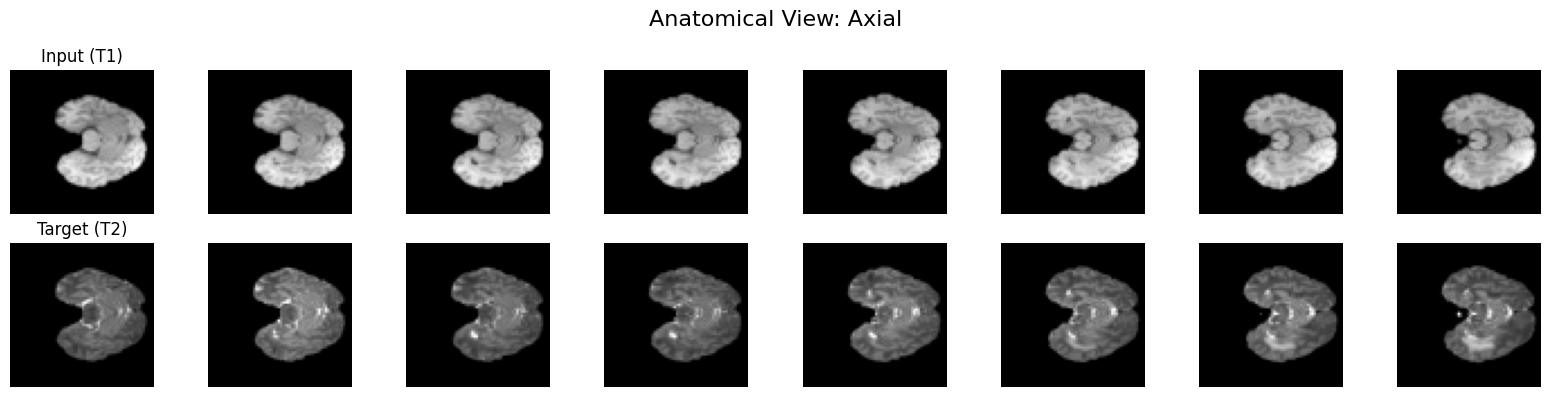

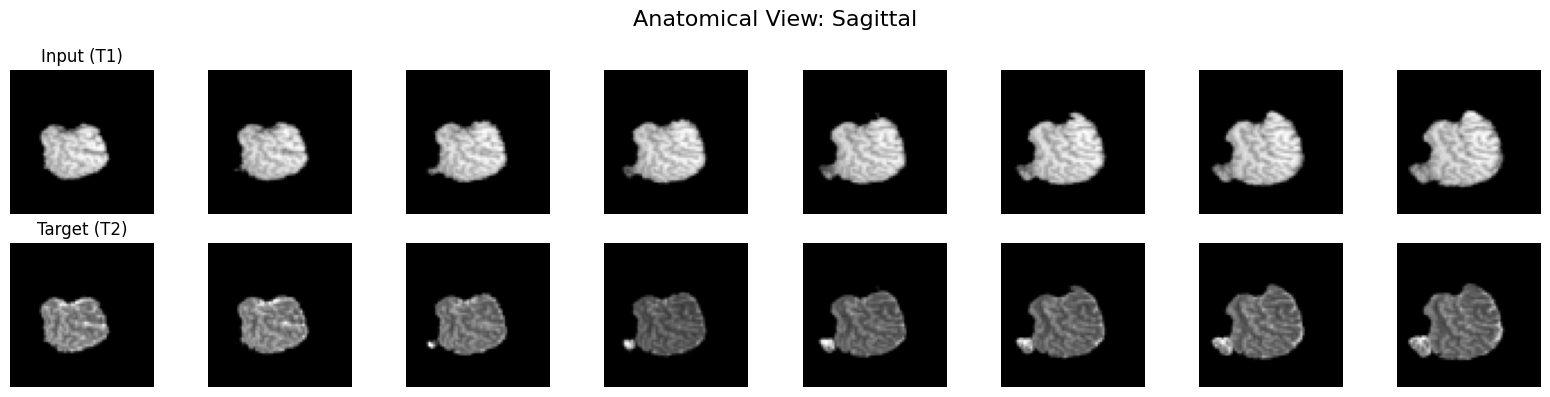

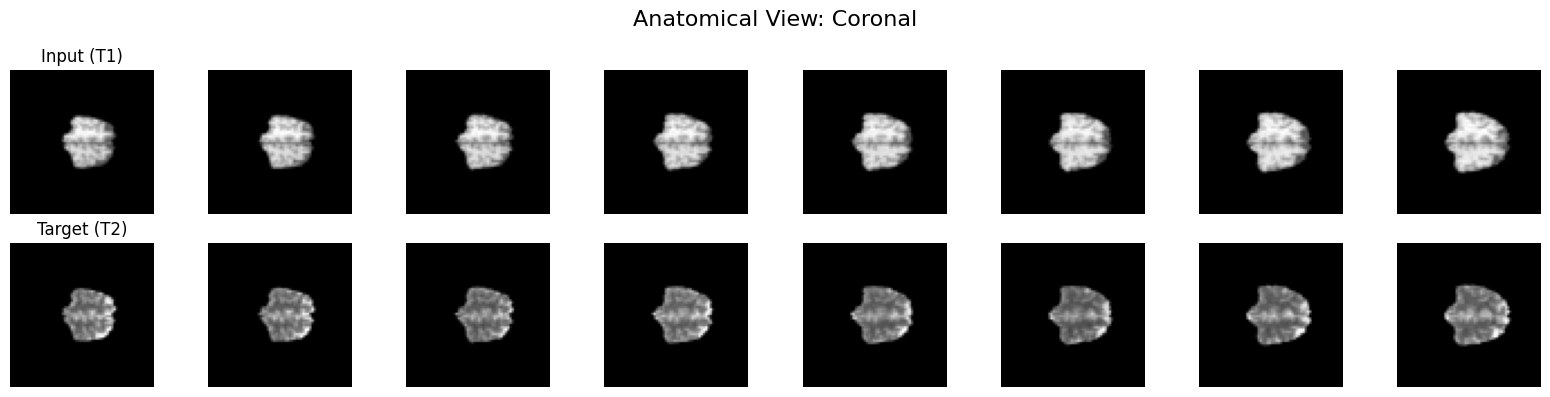

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_representative_pairs(dataset, num_samples=8):
    """
    Visualises a grid of T1 and T2 slices for each anatomical view.

    Args:
        dataset: The dataset containing MRI slices.
        num_samples: Number of pairs to display per view.
    """
    views = ['axial', 'sagittal', 'coronal']

    # Dictionary to store indices for each view
    indices_by_view = {v: [] for v in views}

    # Iterate through the dataset to collect indices for each view
    # We scan until we have enough samples for all views.
    # Note: Accessing dataset[i] applies the transform (returns tensors).
    print("Collecting samples... (this may take a moment)")
    for i in range(len(dataset)):
        sample = dataset[i]
        view = sample['view']

        if view in indices_by_view and len(indices_by_view[view]) < num_samples:
            indices_by_view[view].append(i)

        # Check if we have collected enough samples for all views
        if all(len(idxs) >= num_samples for idxs in indices_by_view.values()):
            break

    # Generate plots for each view
    for view in views:
        idxs = indices_by_view[view]
        if not idxs:
            continue

        # Create a figure with 2 rows (T1, T2) and 'num_samples' columns
        fig, axes = plt.subplots(2, num_samples, figsize=(2 * num_samples, 4))
        fig.suptitle(f'Anatomical View: {view.capitalize()}', fontsize=16)

        for i, idx in enumerate(idxs):
            sample = dataset[idx]

            # Extract T1 and T2 images
            # .squeeze() removes the channel dimension (1, 64, 64) -> (64, 64)
            # .numpy() converts torch tensor to numpy array for plotting
            t1_img = sample['t1'].squeeze().numpy()
            t2_img = sample['t2'].squeeze().numpy()

            # Plot T1 in the first row
            axes[0, i].imshow(t1_img, cmap='gray')
            axes[0, i].axis('off')

            # Plot T2 in the second row
            axes[1, i].imshow(t2_img, cmap='gray')
            axes[1, i].axis('off')

            # Add labels to the first column to identify rows
            if i == 0:
                axes[0, i].set_title("Input (T1)", fontsize=12)
                axes[1, i].set_title("Target (T2)", fontsize=12)

        plt.tight_layout()
        plt.show()

# Execute the visualization on the training set
visualize_representative_pairs(train_dataset)

<br>

2. **Analyse intensity distributions**  

TRAINING SET ANALYSIS
Extracting intensities from 1000 samples...


100%|██████████| 1000/1000 [00:02<00:00, 415.04it/s]



Train T1 Intensity Statistics:
  Min:     0.0000
  Max:     24810.0625
  Mean:    232.0980
  Std:     785.5726
  Median:  0.0000
  Q1:      0.0000
  Q3:      278.7500

Train T2 Intensity Statistics:
  Min:     0.0000
  Max:     30859.5000
  Mean:    271.5786
  Std:     975.3288
  Median:  0.0000
  Q1:      0.0000
  Q3:      272.6000

VALIDATION SET ANALYSIS
Extracting intensities from 500 samples...


100%|██████████| 500/500 [00:01<00:00, 424.24it/s]



Valid T1 Intensity Statistics:
  Min:     0.0000
  Max:     25699.8125
  Mean:    438.0156
  Std:     2071.0410
  Median:  0.0000
  Q1:      0.0000
  Q3:      269.6875

Valid T2 Intensity Statistics:
  Min:     0.0000
  Max:     29715.3340
  Mean:    362.6793
  Std:     1409.4421
  Median:  0.0000
  Q1:      0.0000
  Q3:      298.5625


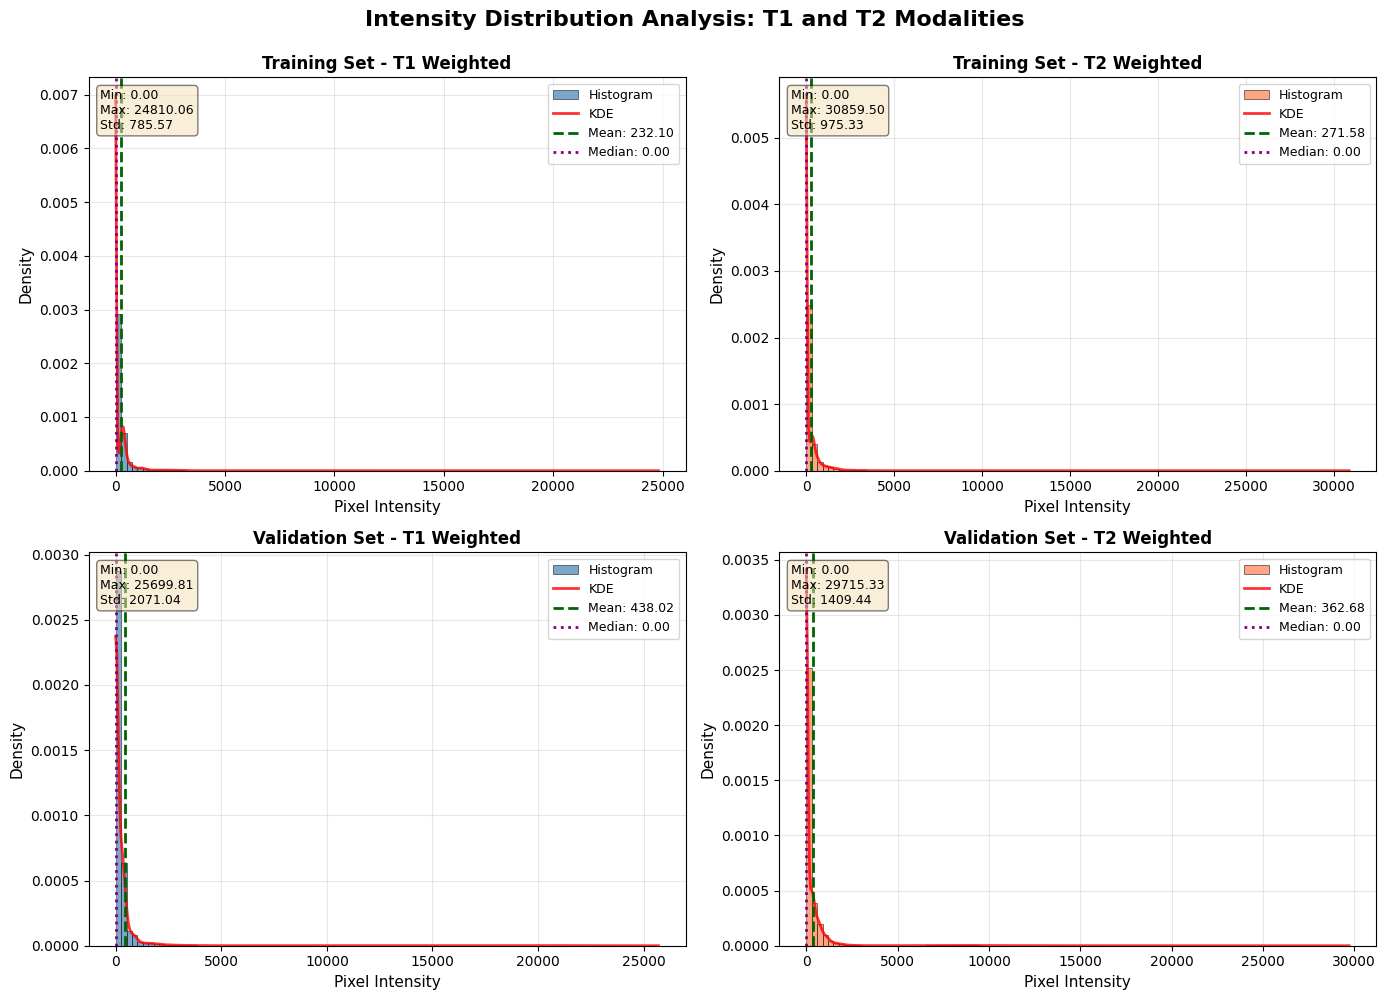

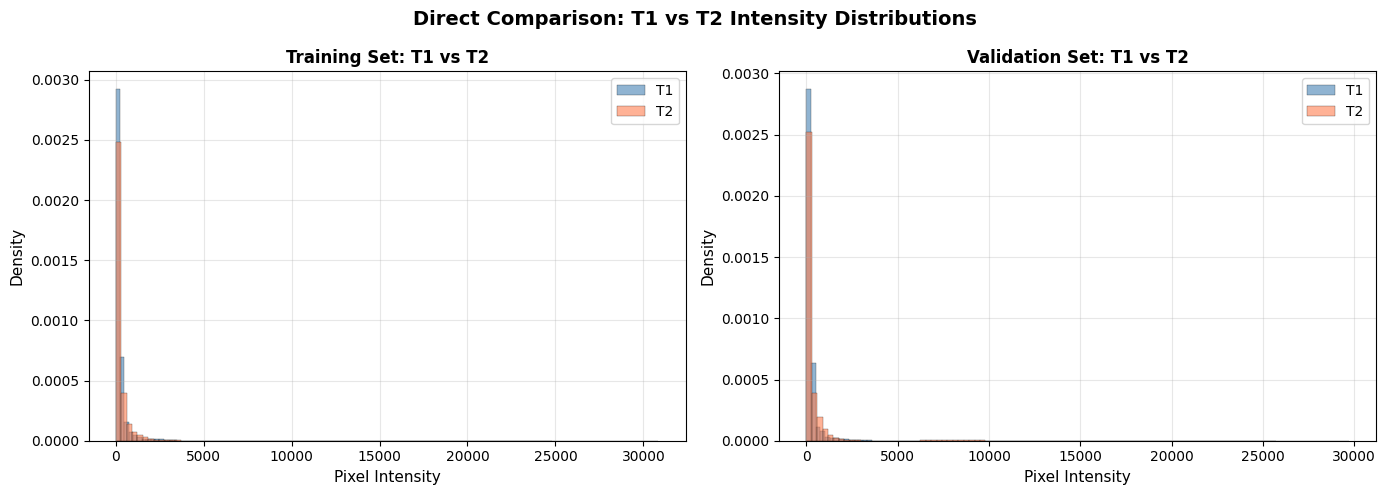


KEY OBSERVATIONS

1. Intensity Ranges:
   - T1 range: [0.00, 24810.06] (span: 24810.06)
   - T2 range: [0.00, 30859.50] (span: 30859.50)

2. Distribution Characteristics:
   - T1 mean: 232.10, std: 785.57
   - T2 mean: 271.58, std: 975.33

3. Train-Validation Consistency:
   - T1 mean difference: 205.9176
   - T2 mean difference: 91.1007
   - Assessment: Check for distribution shift

4. Preprocessing Recommendations:
   - Both modalities have different intensity ranges and distributions
   - Normalization is essential for stable neural network training
   - Consider per-slice normalization to handle inter-patient variability
   - Option 1: Min-max scaling to [0, 1]
   - Option 2: Z-score normalization (mean=0, std=1)
   - Option 3: Percentile-based clipping + scaling


In [6]:
# ============================================================================
# 2. Analyze Intensity Distributions
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def extract_intensity_statistics(dataset, num_samples=1000, seed=42):
    """
    Extract pixel intensity values from a random sample of the dataset.

    Args:
        dataset: HuggingFace dataset with 't1' and 't2' keys
        num_samples: Number of slices to sample for analysis
        seed: Random seed for reproducibility

    Returns:
        dict: Contains 't1_intensities' and 't2_intensities' as flattened arrays
    """
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Randomly sample indices from the dataset
    total_samples = len(dataset)
    sample_indices = np.random.choice(total_samples,
                                     size=min(num_samples, total_samples),
                                     replace=False)

    # Initialize lists to collect intensity values
    t1_intensities = []
    t2_intensities = []

    print(f"Extracting intensities from {len(sample_indices)} samples...")

    # Extract pixel values from sampled slices
    for idx in tqdm(sample_indices):
        sample = dataset[int(idx)]  # Get sample at index

        # Extract T1 and T2 tensors and flatten to 1D arrays
        # Each slice is shape (1, 64, 64), we flatten to get all pixel values
        t1_pixels = sample['t1'].numpy().flatten()
        t2_pixels = sample['t2'].numpy().flatten()

        t1_intensities.append(t1_pixels)
        t2_intensities.append(t2_pixels)

    # Concatenate all pixel values into single arrays
    t1_intensities = np.concatenate(t1_intensities)
    t2_intensities = np.concatenate(t2_intensities)

    return {
        't1_intensities': t1_intensities,
        't2_intensities': t2_intensities
    }


def compute_statistics(intensities, modality_name):
    """
    Compute and print descriptive statistics for intensity values.

    Args:
        intensities: Array of pixel intensity values
        modality_name: String identifier for the modality (e.g., 'T1', 'T2')
    """
    stats = {
        'min': np.min(intensities),
        'max': np.max(intensities),
        'mean': np.mean(intensities),
        'std': np.std(intensities),
        'median': np.median(intensities),
        'q1': np.percentile(intensities, 25),
        'q3': np.percentile(intensities, 75),
    }

    print(f"\n{modality_name} Intensity Statistics:")
    print(f"  Min:     {stats['min']:.4f}")
    print(f"  Max:     {stats['max']:.4f}")
    print(f"  Mean:    {stats['mean']:.4f}")
    print(f"  Std:     {stats['std']:.4f}")
    print(f"  Median:  {stats['median']:.4f}")
    print(f"  Q1:      {stats['q1']:.4f}")
    print(f"  Q3:      {stats['q3']:.4f}")

    return stats


# Extract intensities from training set
print("="*60)
print("TRAINING SET ANALYSIS")
print("="*60)
train_intensities = extract_intensity_statistics(train_dataset, num_samples=1000)

train_t1_stats = compute_statistics(train_intensities['t1_intensities'], 'Train T1')
train_t2_stats = compute_statistics(train_intensities['t2_intensities'], 'Train T2')


# Extract intensities from validation set
print("\n" + "="*60)
print("VALIDATION SET ANALYSIS")
print("="*60)
valid_intensities = extract_intensity_statistics(valid_dataset, num_samples=500)

valid_t1_stats = compute_statistics(valid_intensities['t1_intensities'], 'Valid T1')
valid_t2_stats = compute_statistics(valid_intensities['t2_intensities'], 'Valid T2')


# ============================================================================
# Visualization: Intensity Distribution Histograms
# ============================================================================

def plot_intensity_distributions(train_intensities, valid_intensities):
    """
    Create comprehensive visualization of intensity distributions.

    Plots 2x2 grid showing:
    - Top row: Training set T1 and T2 histograms
    - Bottom row: Validation set T1 and T2 histograms

    Each histogram includes:
    - Histogram bars
    - Kernel Density Estimate (KDE) overlay
    - Mean and median lines
    - Statistics annotation
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Intensity Distribution Analysis: T1 and T2 Modalities',
                 fontsize=16, fontweight='bold', y=0.995)

    # Define plot configurations for each subplot
    plot_configs = [
        {
            'data': train_intensities['t1_intensities'],
            'ax': axes[0, 0],
            'title': 'Training Set - T1 Weighted',
            'color': 'steelblue',
            'stats': train_t1_stats
        },
        {
            'data': train_intensities['t2_intensities'],
            'ax': axes[0, 1],
            'title': 'Training Set - T2 Weighted',
            'color': 'coral',
            'stats': train_t2_stats
        },
        {
            'data': valid_intensities['t1_intensities'],
            'ax': axes[1, 0],
            'title': 'Validation Set - T1 Weighted',
            'color': 'steelblue',
            'stats': valid_t1_stats
        },
        {
            'data': valid_intensities['t2_intensities'],
            'ax': axes[1, 1],
            'title': 'Validation Set - T2 Weighted',
            'color': 'coral',
            'stats': valid_t2_stats
        }
    ]

    # Create each subplot
    for config in plot_configs:
        ax = config['ax']
        data = config['data']
        stats = config['stats']

        # Plot histogram with density normalization
        # bins=100 provides good granularity for intensity distributions
        # density=True normalizes to create probability density
        n, bins, patches = ax.hist(data, bins=100, density=True,
                                    alpha=0.7, color=config['color'],
                                    edgecolor='black', linewidth=0.5,
                                    label='Histogram')

        # Add Kernel Density Estimate (KDE) for smooth distribution
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 500)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2,
                label='KDE', alpha=0.8)

        # Add vertical lines for mean and median
        ax.axvline(stats['mean'], color='darkgreen', linestyle='--',
                   linewidth=2, label=f"Mean: {stats['mean']:.2f}")
        ax.axvline(stats['median'], color='purple', linestyle=':',
                   linewidth=2, label=f"Median: {stats['median']:.2f}")

        # Formatting
        ax.set_xlabel('Pixel Intensity', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title(config['title'], fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)

        # Add text box with key statistics
        textstr = f"Min: {stats['min']:.2f}\nMax: {stats['max']:.2f}\nStd: {stats['std']:.2f}"
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.02, 0.97, textstr, transform=ax.transAxes,
                fontsize=9, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()


# Generate the visualization
plot_intensity_distributions(train_intensities, valid_intensities)


# ============================================================================
# Additional Analysis: Compare T1 vs T2 Distributions Directly
# ============================================================================

def plot_comparative_distributions():
    """
    Create side-by-side comparison of T1 and T2 distributions.

    This helps visualize the differences between modalities more clearly
    by overlaying them on the same axes.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Direct Comparison: T1 vs T2 Intensity Distributions',
                 fontsize=14, fontweight='bold')

    # Training set comparison
    axes[0].hist(train_intensities['t1_intensities'], bins=100,
                 density=True, alpha=0.6, color='steelblue',
                 label='T1', edgecolor='black', linewidth=0.3)
    axes[0].hist(train_intensities['t2_intensities'], bins=100,
                 density=True, alpha=0.6, color='coral',
                 label='T2', edgecolor='black', linewidth=0.3)
    axes[0].set_xlabel('Pixel Intensity', fontsize=11)
    axes[0].set_ylabel('Density', fontsize=11)
    axes[0].set_title('Training Set: T1 vs T2', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Validation set comparison
    axes[1].hist(valid_intensities['t1_intensities'], bins=100,
                 density=True, alpha=0.6, color='steelblue',
                 label='T1', edgecolor='black', linewidth=0.3)
    axes[1].hist(valid_intensities['t2_intensities'], bins=100,
                 density=True, alpha=0.6, color='coral',
                 label='T2', edgecolor='black', linewidth=0.3)
    axes[1].set_xlabel('Pixel Intensity', fontsize=11)
    axes[1].set_ylabel('Density', fontsize=11)
    axes[1].set_title('Validation Set: T1 vs T2', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Generate comparative visualization
plot_comparative_distributions()


# ============================================================================
# Key Observations and Insights
# ============================================================================

print("\n" + "="*60)
print("KEY OBSERVATIONS")
print("="*60)

# Compare ranges
t1_range = train_t1_stats['max'] - train_t1_stats['min']
t2_range = train_t2_stats['max'] - train_t2_stats['min']

print(f"\n1. Intensity Ranges:")
print(f"   - T1 range: [{train_t1_stats['min']:.2f}, {train_t1_stats['max']:.2f}] (span: {t1_range:.2f})")
print(f"   - T2 range: [{train_t2_stats['min']:.2f}, {train_t2_stats['max']:.2f}] (span: {t2_range:.2f})")

# Compare distributions
print(f"\n2. Distribution Characteristics:")
print(f"   - T1 mean: {train_t1_stats['mean']:.2f}, std: {train_t1_stats['std']:.2f}")
print(f"   - T2 mean: {train_t2_stats['mean']:.2f}, std: {train_t2_stats['std']:.2f}")

# Train-validation consistency
t1_mean_diff = abs(train_t1_stats['mean'] - valid_t1_stats['mean'])
t2_mean_diff = abs(train_t2_stats['mean'] - valid_t2_stats['mean'])

print(f"\n3. Train-Validation Consistency:")
print(f"   - T1 mean difference: {t1_mean_diff:.4f}")
print(f"   - T2 mean difference: {t2_mean_diff:.4f}")
print(f"   - Assessment: {'Good consistency' if max(t1_mean_diff, t2_mean_diff) < 0.1 else 'Check for distribution shift'}")

print(f"\n4. Preprocessing Recommendations:")
print(f"   - Both modalities have different intensity ranges and distributions")
print(f"   - Normalization is essential for stable neural network training")
print(f"   - Consider per-slice normalization to handle inter-patient variability")
print(f"   - Option 1: Min-max scaling to [0, 1]")
print(f"   - Option 2: Z-score normalization (mean=0, std=1)")
print(f"   - Option 3: Percentile-based clipping + scaling")

<br>

3. **Design a simple intensity pre-processing transform**

In [7]:
def normalize_slice(image, eps=1e-8):
    """
    Per-slice min-max normalization to [0, 1], ignoring background zeros.
    """
    mask = image > 0

    if not mask.any():
        return image.float()

    brain_pixels = image[mask]
    min_val = brain_pixels.min()
    max_val = brain_pixels.max()

    normalized = torch.zeros_like(image, dtype=torch.float32)

    if max_val - min_val > eps:
        normalized[mask] = (image[mask] - min_val) / (max_val - min_val + eps)
    else:
        normalized[mask] = 0.5

    return normalized


def preprocessing_transform(sample):
    """Apply normalization to both T1 and T2."""
    if "t1" in sample:
        t1_tensor = torch.tensor(sample["t1"], dtype=torch.float32)
        sample["t1"] = normalize_slice(t1_tensor)

    if "t2" in sample:
        t2_tensor = torch.tensor(sample["t2"], dtype=torch.float32)
        sample["t2"] = normalize_slice(t2_tensor)

    return sample


train_dataset_normalized = train_dataset.with_transform(preprocessing_transform)
valid_dataset_normalized = valid_dataset.with_transform(preprocessing_transform)

In [8]:
train_norm_intensities = extract_intensity_statistics(train_dataset_normalized, num_samples=1000, seed=42)
valid_norm_intensities = extract_intensity_statistics(valid_dataset_normalized, num_samples=500, seed=42)

train_t1_norm_stats = compute_statistics(train_norm_intensities['t1_intensities'], 'Train T1 (Normalized)')
train_t2_norm_stats = compute_statistics(train_norm_intensities['t2_intensities'], 'Train T2 (Normalized)')
valid_t1_norm_stats = compute_statistics(valid_norm_intensities['t1_intensities'], 'Valid T1 (Normalized)')
valid_t2_norm_stats = compute_statistics(valid_norm_intensities['t2_intensities'], 'Valid T2 (Normalized)')

Extracting intensities from 1000 samples...


100%|██████████| 1000/1000 [00:02<00:00, 424.95it/s]


Extracting intensities from 500 samples...


100%|██████████| 500/500 [00:01<00:00, 424.00it/s]



Train T1 (Normalized) Intensity Statistics:
  Min:     0.0000
  Max:     1.0000
  Mean:    0.2288
  Std:     0.3342
  Median:  0.0000
  Q1:      0.0000
  Q3:      0.5691

Train T2 (Normalized) Intensity Statistics:
  Min:     0.0000
  Max:     1.0000
  Mean:    0.1398
  Std:     0.2155
  Median:  0.0000
  Q1:      0.0000
  Q3:      0.2947

Valid T1 (Normalized) Intensity Statistics:
  Min:     0.0000
  Max:     1.0000
  Mean:    0.2356
  Std:     0.3374
  Median:  0.0000
  Q1:      0.0000
  Q3:      0.5710

Valid T2 (Normalized) Intensity Statistics:
  Min:     0.0000
  Max:     1.0000
  Mean:    0.1547
  Std:     0.2346
  Median:  0.0000
  Q1:      0.0000
  Q3:      0.3173


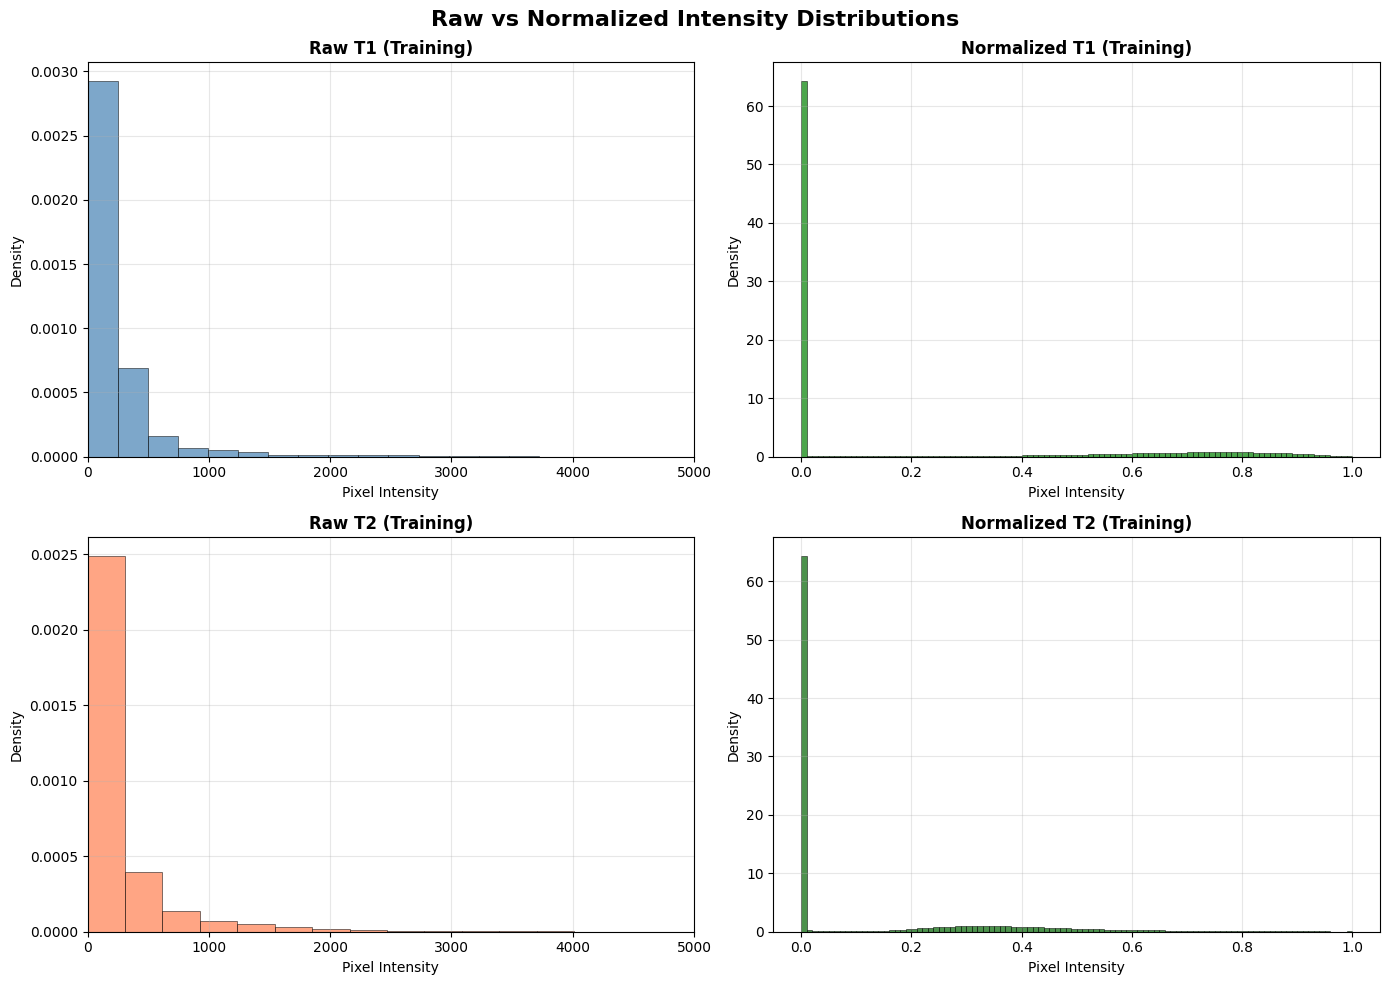

In [9]:
# Compare raw vs normalized distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Raw vs Normalized Intensity Distributions', fontsize=16, fontweight='bold')

# Raw T1
axes[0, 0].hist(train_intensities['t1_intensities'], bins=100, density=True,
                alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
axes[0, 0].set_xlabel('Pixel Intensity')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Raw T1 (Training)', fontweight='bold')
axes[0, 0].set_xlim([0, 5000])
axes[0, 0].grid(True, alpha=0.3)

# Normalized T1
axes[0, 1].hist(train_norm_intensities['t1_intensities'], bins=100, density=True,
                alpha=0.7, color='green', edgecolor='black', linewidth=0.5)
axes[0, 1].set_xlabel('Pixel Intensity')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Normalized T1 (Training)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Raw T2
axes[1, 0].hist(train_intensities['t2_intensities'], bins=100, density=True,
                alpha=0.7, color='coral', edgecolor='black', linewidth=0.5)
axes[1, 0].set_xlabel('Pixel Intensity')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Raw T2 (Training)', fontweight='bold')
axes[1, 0].set_xlim([0, 5000])
axes[1, 0].grid(True, alpha=0.3)

# Normalized T2
axes[1, 1].hist(train_norm_intensities['t2_intensities'], bins=100, density=True,
                alpha=0.7, color='darkgreen', edgecolor='black', linewidth=0.5)
axes[1, 1].set_xlabel('Pixel Intensity')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Normalized T2 (Training)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

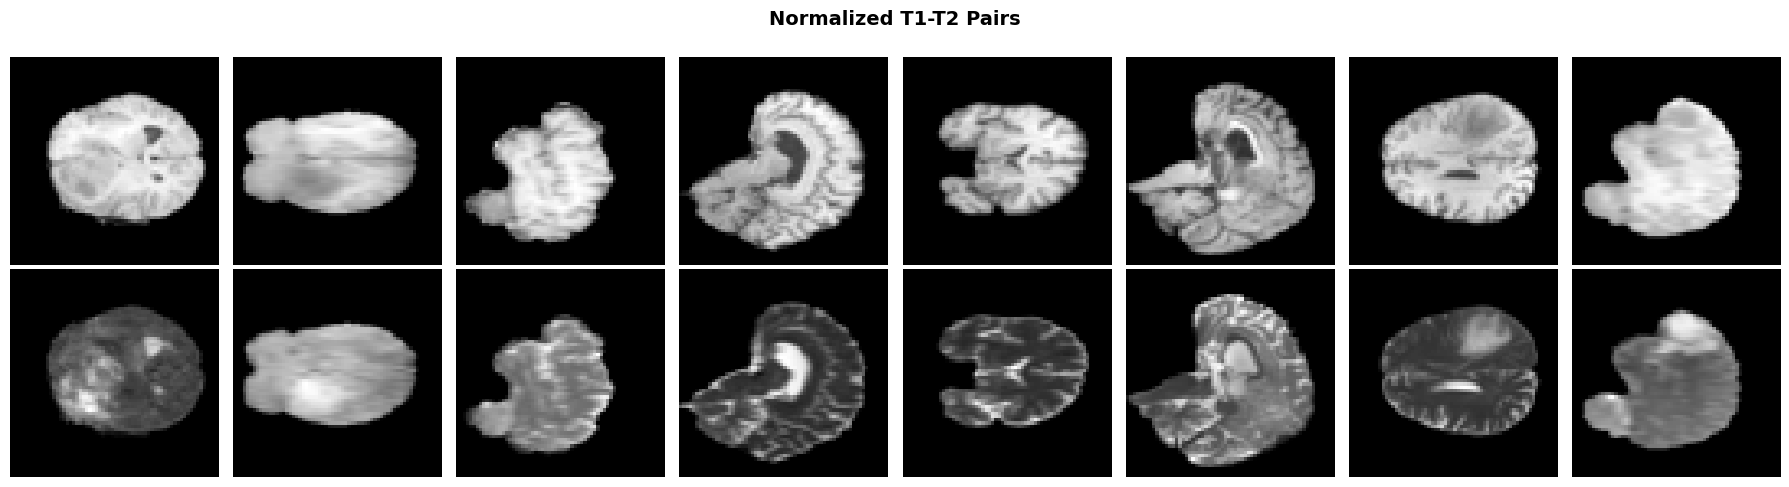

In [10]:
# Visualize normalized T1-T2 pairs to verify preprocessing
fig, axes = plt.subplots(2, 8, figsize=(18, 5))
fig.suptitle('Normalized T1-T2 Pairs', fontsize=14, fontweight='bold')

np.random.seed(42)
indices = np.random.choice(len(train_dataset_normalized), 8, replace=False)

for i, idx in enumerate(indices):
    sample = train_dataset_normalized[int(idx)]
    t1 = sample['t1'].squeeze().numpy()
    t2 = sample['t2'].squeeze().numpy()

    axes[0, i].imshow(t1, cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('T1', fontsize=12, fontweight='bold')

    axes[1, i].imshow(t2, cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('T2', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
# Check train-validation consistency after normalization
t1_mean_diff = abs(train_t1_norm_stats['mean'] - valid_t1_norm_stats['mean'])
t2_mean_diff = abs(train_t2_norm_stats['mean'] - valid_t2_norm_stats['mean'])

print(f"Train-Validation Consistency After Normalization:")
print(f"  T1 mean difference: {t1_mean_diff:.4f}")
print(f"  T2 mean difference: {t2_mean_diff:.4f}")

Train-Validation Consistency After Normalization:
  T1 mean difference: 0.0068
  T2 mean difference: 0.0150


<br><br>

## 1.B) Modality Translation (T1 → T2)

In this part you will build an **image-to-image model** that takes a T1-weighted slice as input and predicts the corresponding T2-weighted slice. Each training example is therefore a pair $(\text{T1}, \text{T2})$ with matching spatial dimensions.

You are free to design the model architecture, but it must satisfy the following requirements:

- It should operate on 2D slices and produce an output with the **same spatial resolution** as the input
- It should take `t1` as input and learn to approximate `t2` as output, using the pre-processed data from Part 1.A.  

In designing your solution, you must determine:

- a **suitable architecture**, keeping in mind that simpler models should remain functional and that more complex designs may yield improved performance;  
- the **loss function** and **optimisation setup** you believe appropriate for this task;  
- the **evaluation strategy**, including at least one quantitative metric and the qualitative visualisation of predicted T2 images.

Key points to consider:

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem. **Strong solutions will ensure that the model can both preserve image quality and generalise well to the validation set.**

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays example outputs of your **final trained model on the validation set**, as well as at least one plot showing how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [12]:
# Dataset wrapper for PyTorch DataLoader
class MRIDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Explicitly cast idx to Python int to avoid TypeError with HuggingFace datasets
        sample = self.dataset[int(idx)]
        return sample['t1'], sample['t2']


def create_subset_dataset(dataset, num_samples, seed=42):
    """Creates a random subset of a HuggingFace dataset."""
    np.random.seed(seed)
    total_samples = len(dataset)
    if num_samples >= total_samples:
        return dataset
    indices = np.random.choice(total_samples, num_samples, replace=False)
    return Subset(dataset, indices)


# Create data loaders
train_full_mri_dataset = MRIDataset(train_dataset_normalized)
valid_full_mri_dataset = MRIDataset(valid_dataset_normalized)


# 2. Then, create subsets from these MRIDataset instances.
train_sub_mri_dataset = create_subset_dataset(train_full_mri_dataset, num_samples=10000)
valid_sub_mri_dataset = create_subset_dataset(valid_full_mri_dataset, num_samples=3000)

train_loader = DataLoader(train_full_mri_dataset, batch_size=128, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_full_mri_dataset, batch_size=128, shuffle=False, num_workers=4)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")

Training batches: 909
Validation batches: 308


In [13]:
# U-Net Architecture
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channels):
        """Double convolution block: Conv-BN-ReLU-Conv-BN-ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        out = self.out(dec1)

        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {total_params:,}")
print(f"Device: {device}")

Model parameters: 31,042,369
Device: cuda


Training the above model took around an hours for an epoch, making it unsustainable for this task. Let's try implementing a smaller U-Net with fewer channels

In [14]:
class LightUNet(nn.Module):
    """Smaller U-Net: 3 levels instead of 4, fewer channels."""

    def __init__(self, in_channels=1, out_channels=1):
        super(LightUNet, self).__init__()

        # Encoder - fewer channels
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)

        self.out = nn.Conv2d(32, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return self.out(dec1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightUNet().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {total_params:,}")  # 2M instead of 31M

Model parameters: 1,927,841


In [18]:
# Loss function and evaluation metrics

def train_loss_L1(pred, target):
    """Just L1 for training - fast and effective."""
    return F.l1_loss(pred, target)

def train_loss_L2(pred, target):
    """Just L1 for training - fast and effective."""
    return F.mse_loss(pred, target)

def calculate_metrics(pred, target):
    mae = F.l1_loss(pred, target).item()
    return {'mae': mae}

def evaluate(model, loader, device):
    """Evaluate on validation set."""
    model.eval()
    all_metrics = defaultdict(list)

    with torch.no_grad():
        for t1, t2 in loader:
            t1, t2 = t1.to(device), t2.to(device)
            pred = model(t1)

            metrics = calculate_metrics(pred, t2)
            for k, v in metrics.items():
                all_metrics[k].append(v)

    return {k: np.mean(v) for k, v in all_metrics.items()}

In [19]:
# Training and evaluation functions

def train_epoch(model, loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    losses = []

    for t1, t2 in loader:
        t1, t2 = t1.to(device), t2.to(device)

        optimizer.zero_grad()
        pred = model(t1)
        loss = train_loss_L1(pred, t2)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)


def evaluate(model, loader, device):
    """Evaluate on validation set."""
    model.eval()
    all_metrics = defaultdict(list)

    with torch.no_grad():
        for t1, t2 in loader:
            t1, t2 = t1.to(device), t2.to(device)
            pred = model(t1)

            metrics = calculate_metrics(pred, t2)
            for k, v in metrics.items():
                all_metrics[k].append(v)

    return {k: np.mean(v) for k, v in all_metrics.items()}

In [23]:
# Training configuration
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        factor=0.5, patience=5)

num_epochs = 20
best_val_loss = float('inf')
patience = 8
patience_counter = 0

history = {
    'train_loss': [],
    'val_mae': [],
}

In [24]:
# Training loop
print("Starting training...")

start_time = time.time()

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_metrics = evaluate(model, valid_loader, device)

    history['train_loss'].append(train_loss)
    history['val_mae'].append(val_metrics['mae'])

    scheduler.step(val_metrics['mae'])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val MAE: {val_metrics['mae']:.4f}")

    if val_metrics['mae'] < best_val_loss:
        best_val_loss = val_metrics['mae']
        torch.save(model.state_dict(), 'best_unet_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes")
print(f"Best validation MAE: {best_val_loss:.4f}")

Starting training...
Epoch 1/20
  Train Loss: 0.0296
  Val MAE: 0.0481
Epoch 2/20
  Train Loss: 0.0263
  Val MAE: 0.0465
Epoch 3/20
  Train Loss: 0.0244
  Val MAE: 0.0388
Epoch 4/20
  Train Loss: 0.0233
  Val MAE: 0.0391
Epoch 5/20
  Train Loss: 0.0222
  Val MAE: 0.0424
Epoch 6/20
  Train Loss: 0.0213
  Val MAE: 0.0391
Epoch 7/20
  Train Loss: 0.0210
  Val MAE: 0.0412
Epoch 8/20
  Train Loss: 0.0205
  Val MAE: 0.0373
Epoch 9/20
  Train Loss: 0.0201
  Val MAE: 0.0395
Epoch 10/20
  Train Loss: 0.0199
  Val MAE: 0.0376
Epoch 11/20
  Train Loss: 0.0197
  Val MAE: 0.0378
Epoch 12/20
  Train Loss: 0.0196
  Val MAE: 0.0386
Epoch 13/20
  Train Loss: 0.0195
  Val MAE: 0.0384
Epoch 14/20
  Train Loss: 0.0197
  Val MAE: 0.0384
Epoch 15/20
  Train Loss: 0.0175
  Val MAE: 0.0378
Epoch 16/20
  Train Loss: 0.0172
  Val MAE: 0.0366
Epoch 17/20
  Train Loss: 0.0171
  Val MAE: 0.0371
Epoch 18/20
  Train Loss: 0.0170
  Val MAE: 0.0362
Epoch 19/20
  Train Loss: 0.0169
  Val MAE: 0.0358
Epoch 20/20
  Train

In [25]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_unet_model.pth'))
final_metrics = evaluate(model, valid_loader, device)

print("\nFinal Validation Metrics:")
print(f"  MAE:  {final_metrics['mae']:.4f}")


Final Validation Metrics:
  MAE:  0.0358


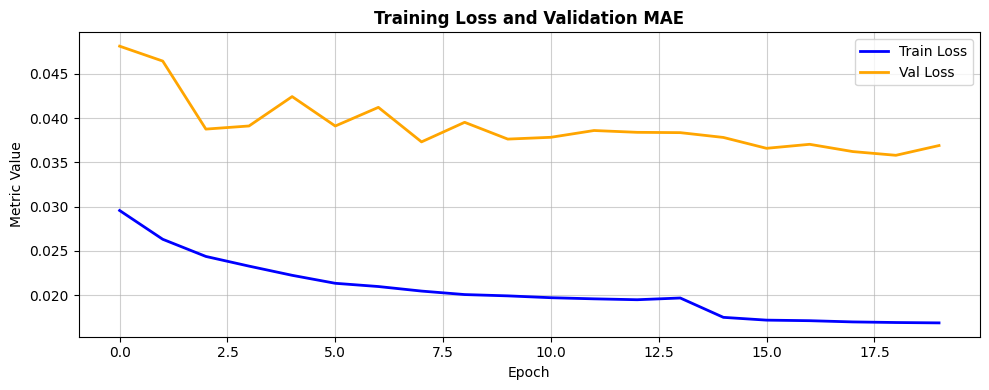

In [29]:
# Plot training curves in a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Plot both metrics on the same axes
ax.plot(history['train_loss'], label='Train Loss', linewidth=2, color='blue')
ax.plot(history['val_mae'], label='Val Loss', linewidth=2, color='orange')

ax.set_xlabel('Epoch')
ax.set_ylabel('Metric Value')
ax.set_title('Training Loss and Validation MAE', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

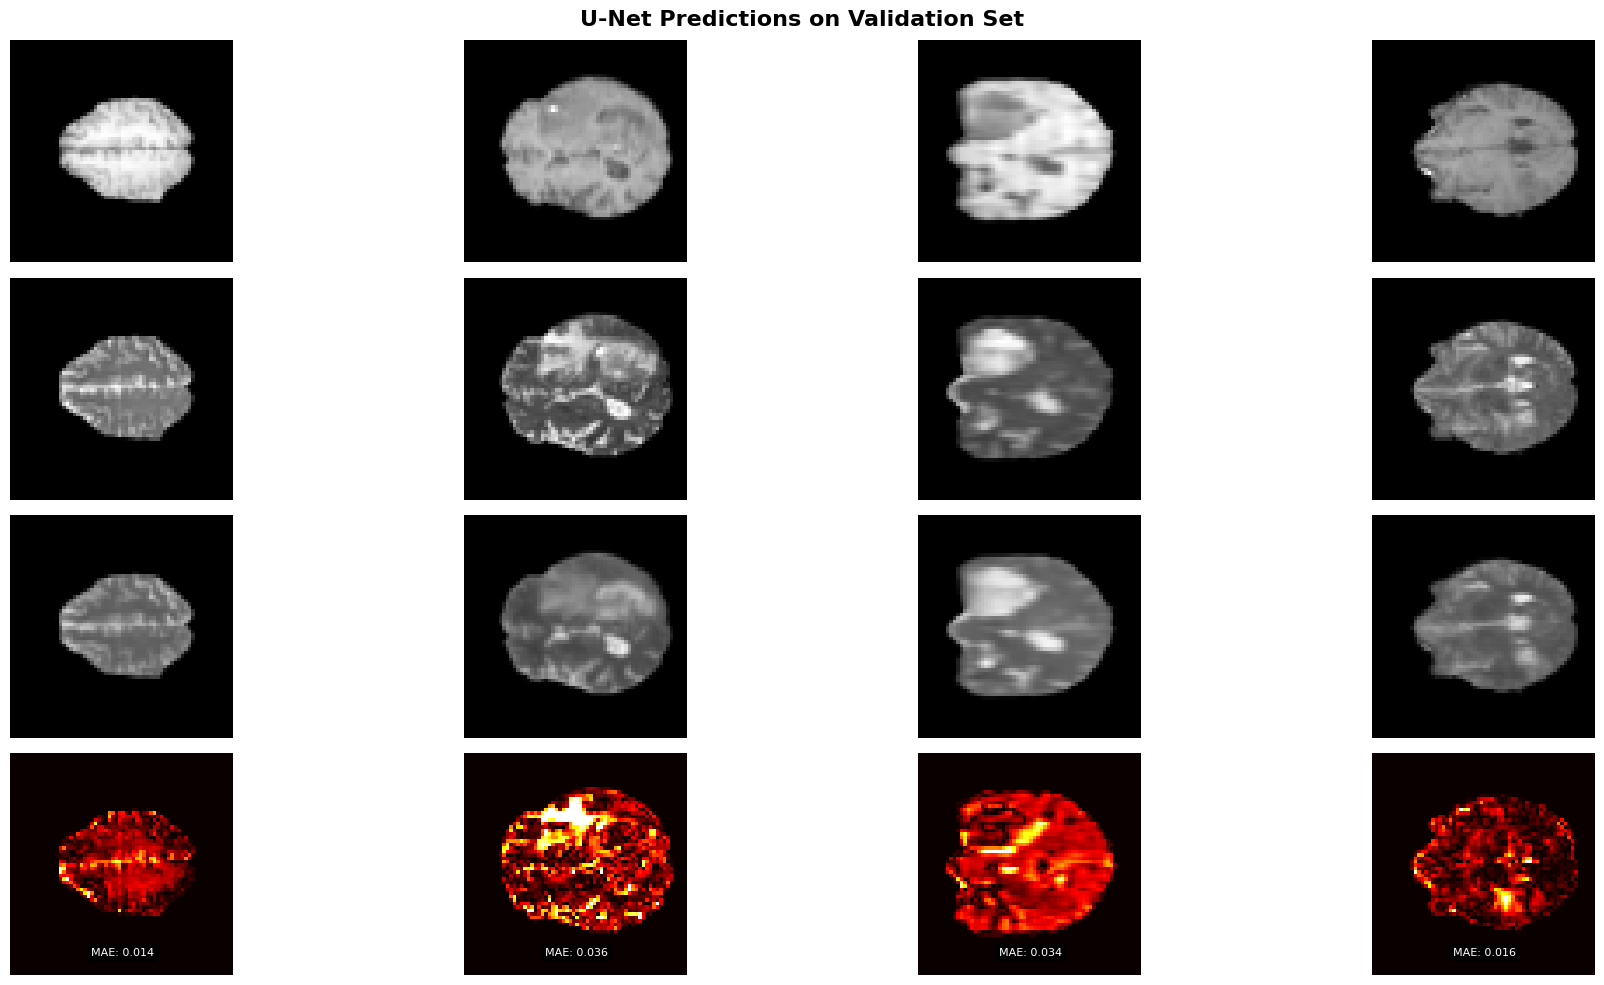

In [31]:
# Visualize predictions on validation set
def visualize_predictions(model, dataset, device, num_examples=8):
    """Display input T1, ground truth T2, predicted T2, and error maps."""
    model.eval()

    fig, axes = plt.subplots(4, num_examples, figsize=(20, 10))
    fig.suptitle('U-Net Predictions on Validation Set', fontsize=16, fontweight='bold')

    np.random.seed(42)
    indices = np.random.choice(len(dataset), num_examples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            t1, t2 = dataset[int(idx)]
            t1_batch = t1.unsqueeze(0).to(device)

            pred = model(t1_batch).squeeze().cpu().numpy()
            t1_np = t1.squeeze().numpy()
            t2_np = t2.squeeze().numpy()
            error = np.abs(t2_np - pred)

            axes[0, i].imshow(t1_np, cmap='gray', vmin=0, vmax=1)
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_ylabel('Input T1', fontsize=12, fontweight='bold')

            axes[1, i].imshow(t2_np, cmap='gray', vmin=0, vmax=1)
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_ylabel('Ground Truth T2', fontsize=12, fontweight='bold')

            axes[2, i].imshow(pred, cmap='gray', vmin=0, vmax=1)
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_ylabel('Predicted T2', fontsize=12, fontweight='bold')

            axes[3, i].imshow(error, cmap='hot', vmin=0, vmax=0.3)
            axes[3, i].axis('off')
            if i == 0:
                axes[3, i].set_ylabel('Absolute Error', fontsize=12, fontweight='bold')

            mae = np.mean(error)
            axes[3, i].text(32, 58, f'MAE: {mae:.3f}',
                           ha='center', color='white', fontsize=8,
                           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

    plt.tight_layout()
    plt.show()


visualize_predictions(model, valid_full_mri_dataset, device, num_examples=4)

In [ ]:
# Analyze predictions by anatomical view
def analyze_by_view(model, dataset, device):
    """Compare performance across different anatomical views."""
    model.eval()

    view_metrics = {'axial': [], 'sagittal': [], 'coronal': []}

    with torch.no_grad():
        for idx in range(len(dataset)):
            # 'dataset' here is a Subset object.
            # dataset.indices[idx] gives the actual index in the wrapped dataset.
            # dataset.dataset is the MRIDataset object.
            # dataset.dataset.dataset is the original HuggingFace dataset.
            original_hf_dataset = dataset.dataset.dataset
            original_hf_index = dataset.indices[idx]
            sample_with_metadata = original_hf_dataset[int(original_hf_index)] # Cast to int here

            view = sample_with_metadata['view']

            t1, t2 = dataset[idx] # This gets the preprocessed T1, T2 tensors from the MRIDataset
            t1_batch = t1.unsqueeze(0).to(device)
            pred = model(t1_batch)

            metrics = calculate_metrics(pred, t2.unsqueeze(0).to(device))
            view_metrics[view].append(metrics)

    results = {}
    for view, metrics_list in view_metrics.items():
        results[view] = {
            'mae': np.mean([m['mae'] for m in metrics_list]),
        }

    return results


view_results = analyze_by_view(model, valid_mri_dataset, device)

print("\nPerformance by Anatomical View:")
print("="*60)
for view, metrics in view_results.items():
    print(f"\n{view.capitalize()} view:")
    print(f"  MAE:  {metrics['mae']:.4f}")


<br><br>

## 1.C) Discussion (max 250 words)

In this part you should provide a concise written discussion (maximum **250 words**) reflecting on your solution to Part 1.B. Your discussion should address the following points:

1. **Modelling choices and pre-processing**  
   Explain the main decisions behind your model architecture, loss function, and training strategy, and how they relate to the properties of the T1/T2 translation task.

2. **Performance and evaluation**  
   Interpret your **quantitative** results and **qualitative** reconstructions. Comment on how well your model appears to reconstruct `t2` features.

3. **Limitations and possible improvements**  
   Identify the main limitations of your current approach and outline concrete avenues for improvement. You may refer to alternative architectures, loss functions, or improved training and validation procedures.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer

<br>

---

<br>